# ATP Tennis Data - Feature Engineering

In previous notebook, we pre-processed the ATP match data by:
* dropping columns with little data
* cleaning string columns
* imputing any data that we can reasonably impute

For this notebook, we will use the data saved from pre-processing and start doing some basic feature engineering so we can feed  our data to our models to see how we do. My goal is to start training models and see how they do as soon as possible, so we will stick with the following basic feature engineering techniques:
* encode any categorical data - ie, tournament surface, round, winner_ioc, loser_ioc
    * numeric encoding (these are categories that have some type of ordinality or importance)
        * tournament level
        * round of match
    * one hot encoding (non-oridnal categories)
        * tournament id
        * player hand
        * tournament surface
        * player id
        * player origin
* extra month from the tournament date
* label each row with 0 as Player 1 losing to Player 2 and 1 as Player 1 beats Player 2
* remove any remaining columns that we

Output of basic feature engineering:
* tournament
    * tournament id - extract from current tourney_id field
    * tournament level - encode
    * month of tournament - extract from tourney_date
    * year of tournament - extract from tourney_date
    * surface - one hot encode
    * draw size
    * best of
* player 1 and player 2
    * player id
    * rank
    * height
    * ioc - encode
    * age
    * seed
    * hand - encode
* match
    * round - encode
* label
    * whether player 1 beat player 2 - 0 - False, 1 - True
    

## Future:
In a future notebook, I plan on implementing more advanced feature engineering with:
* look up matchup history for players
    * match-up stats for pervious matchups
* add match player record leading up to the match for each player (ie, last X matches)
* look up player stats leading up to match for each player (ie, last X matches)
* contruct 2 entries of data per row since match-up and player record leading up to a match will differe depending on which player is player 1 or 2


## Missing Data:

There are some features that are  missing from our dataset. In the future, we could look into somehow scrapping or manually getting these. I looked at the ATP website to see how to get this data, but it is not readily apparent since each player/tournament has some type of unique identifier on their website that I haven't figure out how to get. Here are some potential features to get i the future:


* tournament
    * tournament location - ie, city, country
    * whether tournament is indoor or outdoors
    * prize money
* player
    * weight
    * player experience - ie, number of years as a pro

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import json
import random
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util.model_util import RSTATE
random.seed(RSTATE)


%matplotlib inline
sns.set()

In [2]:
# Contants
START_YEAR = 1985
END_YEAR = 2019

DATASET_DIR = '../datasets'
MODEL_DIR = '../models'

# sometimes I run these notebooks via command line. Environment variable is set so we know whether we are in DEBUG mode or not
DEBUG = bool(os.environ.get("IPYNB_DEBUG", False))

if DEBUG:
    PREPROCESSED_FILE = f'{DATASET_DIR}/test-preprocessed.csv'
    FEATURE_FILE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features_test.csv'
    FEATURE_FILE_DIFF = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features_test-diff.csv'
    FEATURE_FILE_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features_test-ohe.csv'
    FEATURE_FILE_DIFF_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features_test-diff-ohe.csv'
    FEATURE_FILE_RAW_DIFF_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features_test-raw_diff-ohe.csv'
else:
    # this is the file we generated from our pre-processing notebook
    PREPROCESSED_FILE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_preprocessed.csv'
    FEATURE_FILE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features.csv'
    FEATURE_FILE_DIFF = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features-diff.csv'
    FEATURE_FILE_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features-ohe.csv'
    FEATURE_FILE_DIFF_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features-diff-ohe.csv'
    FEATURE_FILE_RAW_DIFF_OHE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features-raw_diff-ohe.csv'



In [3]:
pre = pd.read_csv(PREPROCESSED_FILE, parse_dates=["tourney_date"])

In [4]:
pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 45 columns):
tourney_id       1000 non-null object
tourney_name     1000 non-null object
surface          1000 non-null object
draw_size        1000 non-null float64
tourney_level    1000 non-null object
tourney_date     1000 non-null datetime64[ns]
match_num        1000 non-null int64
winner_id        1000 non-null int64
winner_seed      1000 non-null float64
winner_name      1000 non-null object
winner_hand      1000 non-null object
winner_ht        1000 non-null float64
winner_ioc       1000 non-null object
winner_age       1000 non-null float64
loser_id         1000 non-null int64
loser_seed       1000 non-null float64
loser_name       1000 non-null object
loser_hand       1000 non-null object
loser_ht         1000 non-null float64
loser_ioc        1000 non-null object
loser_age        1000 non-null float64
score            1000 non-null object
best_of          1000 non-null int64
round    

## Let's look at the data to make sure all the types are correct before we being

In [5]:
pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 45 columns):
tourney_id       1000 non-null object
tourney_name     1000 non-null object
surface          1000 non-null object
draw_size        1000 non-null float64
tourney_level    1000 non-null object
tourney_date     1000 non-null datetime64[ns]
match_num        1000 non-null int64
winner_id        1000 non-null int64
winner_seed      1000 non-null float64
winner_name      1000 non-null object
winner_hand      1000 non-null object
winner_ht        1000 non-null float64
winner_ioc       1000 non-null object
winner_age       1000 non-null float64
loser_id         1000 non-null int64
loser_seed       1000 non-null float64
loser_name       1000 non-null object
loser_hand       1000 non-null object
loser_ht         1000 non-null float64
loser_ioc        1000 non-null object
loser_age        1000 non-null float64
score            1000 non-null object
best_of          1000 non-null int64
round    

In [6]:
pre.sample(5).T

,937,673,226,774,435
tourney_id,2019-0891,2018-m014,2018-m024,2018-0337,2018-0341
tourney_name,pune,moscow,cincinnati masters,vienna,metz
surface,hard,hard,hard,hard,hard
draw_size,32,32,64,32,32
tourney_level,a,a,m,a,a
tourney_date,2018-12-31 00:00:00,2018-10-15 00:00:00,2018-08-13 00:00:00,2018-10-22 00:00:00,2018-09-17 00:00:00
match_num,292,278,286,292,294
winner_id,144719,104312,103819,105453,105430
winner_seed,7,7,2,5,19
winner_name,jaume munar,andreas seppi,roger federer,kei nishikori,radu albot


# Tournament Info

* tournament id - extract from current tourney_id field
* tournament level - one hot encode
* month of tournament - extract from tourney_date
* year of tournament - extract from tourney_date
* surface - one hot encode
* draw size
* best of


### Extract tournment ID aand Encode

Since players may have an affinity for certainly tournaments because of location or conditions, we should include this into our features

First let's rename the columns since it's rather confusing - currently, tourney_id is a composite of {year}-{id}. ID is alphanumeric so we need to encode these

In [7]:
matches = pre
matches = matches.rename({"tourney_id": "tourney_year_plus_id"}, axis=1)
matches["tourney_id"] = matches.tourney_year_plus_id.apply(lambda x: x.split("-")[1])
matches.sample(5, random_state=RSTATE).tourney_id

507    6967
818    0352
452    0568
368     560
242    6242
Name: tourney_id, dtype: object

In [8]:


tidle = LabelEncoder()
tid_labels = tidle.fit_transform(matches['tourney_id'])
tid_map = {label: num for num, label in enumerate(tidle.classes_)}
print(tid_map)

matches["tourney_id_label"] = matches["tourney_id"].map(tid_map)

# save off map to be used later
with open(f'{MODEL_DIR}/tid_map.json', 'w') as file:
    json.dump(tid_map, file)
    
matches.sample(5)[["tourney_id", "tourney_id_label"]]

{'0301': 0, '0319': 1, '0328': 2, '0329': 3, '0337': 4, '0341': 5, '0352': 6, '0414': 7, '0421': 8, '0429': 9, '0451': 10, '0568': 11, '0605': 12, '0891': 13, '5014': 14, '560': 15, '6242': 16, '6967': 17, '7480': 18, '7485': 19, '7581': 20, '7696': 21, 'm001': 22, 'm014': 23, 'm015': 24, 'm020': 25, 'm024': 26, 'm035': 27}


,tourney_id,tourney_id_label
244,6242,16
391,560,15
251,6242,16
199,m024,26
594,5014,14


### Tournament Level

Tournament level does have some type of implicit ordinality to them since tournaments are worth different points according to their levels with 'g' (grand slams) worth the most number of points

We will do a custom encoding for these

Here are the point values for winner the levels:
* g - grand slam - 2000
* f - tour final - 1500
* m - masters - 1000
* a - other tour event - anywhere between 250 to 500 depending on the series

In [9]:
np.unique(matches.tourney_level)

array(['a', 'f', 'g', 'm'], dtype=object)

In [10]:
import json

level_map = {'g': 1, 'f': 2, 'm': 3, 'a': 4}
matches["tourney_level_label"] = matches['tourney_level'].map(level_map)
# let's check our work
matches.sample(5)[["tourney_level", "tourney_level_label"]]

# let's save off the map for later use
with open(f'{MODEL_DIR}/tourney_level_map.json', 'w') as file:
    json.dump(level_map, file)

### Tournamant year and Month

We can extract this from the tourney_date

In [11]:
matches["tourney_year"] = matches.tourney_date.dt.year
matches["tourney_month"] = matches.tourney_date.dt.month
matches.sample(5)[["tourney_year", "tourney_month", "tourney_date"]]

,tourney_year,tourney_month,tourney_date
387,2018,8,2018-08-27
839,2018,11,2018-11-05
406,2018,8,2018-08-27
31,2018,7,2018-07-30
16,2018,7,2018-07-23


### Tournament Surface

There is no ordinality here so we can just use a label encoder

In [12]:

surface_le = LabelEncoder()
surface_labels = surface_le.fit_transform(matches['surface'])
surface_map = {label: num for num, label in enumerate(surface_le.classes_)}
print(surface_map)

matches["surface_label"] = matches["surface"].map(surface_map)

# save off map to be used later
with open(f'{MODEL_DIR}/surface_map.json', 'w') as file:
    json.dump(surface_map, file)
    
matches.sample(5)[["surface", "surface_label"]]

{'clay': 0, 'hard': 1}


,surface,surface_label
199,hard,1
881,hard,1
719,hard,1
488,hard,1
690,hard,1


# Generate Player Features

Most are already numbers that we can feed into the model - we will just keep these for now

### Player origin (ioc)

Again there is no ordinality to this so we will use the LabelEncoder

In [13]:
ioc_le = LabelEncoder()
# we have to append loser and winner list to get comprehensive list
ioc_labels = ioc_le.fit_transform(matches["loser_ioc"].append(matches["winner_ioc"]))
ioc_map = {label: num for num, label in enumerate(ioc_le.classes_)}
print(ioc_map)

matches["loser_ioc_label"] = matches["loser_ioc"].map(ioc_map)
matches["winner_ioc_label"] = matches["winner_ioc"].map(ioc_map)

# save off map to be used later
with open(f'{MODEL_DIR}/ioc_map.json', 'w') as file:
    json.dump(ioc_map, file)
    
matches.sample(5)[["loser_ioc", "loser_ioc_label", "winner_ioc", "winner_ioc_label"]]

{'arg': 0, 'aus': 1, 'aut': 2, 'bel': 3, 'bih': 4, 'blr': 5, 'bra': 6, 'bul': 7, 'can': 8, 'chi': 9, 'chn': 10, 'col': 11, 'cro': 12, 'cyp': 13, 'cze': 14, 'egy': 15, 'esa': 16, 'esp': 17, 'est': 18, 'fra': 19, 'gbr': 20, 'ger': 21, 'gre': 22, 'hun': 23, 'ind': 24, 'ita': 25, 'jpn': 26, 'kaz': 27, 'kor': 28, 'lat': 29, 'ltu': 30, 'lux': 31, 'mda': 32, 'mex': 33, 'ned': 34, 'nor': 35, 'nzl': 36, 'pol': 37, 'por': 38, 'qat': 39, 'rou': 40, 'rsa': 41, 'rus': 42, 'slo': 43, 'srb': 44, 'sui': 45, 'svk': 46, 'swe': 47, 'tpe': 48, 'tun': 49, 'tur': 50, 'ukr': 51, 'uru': 52, 'usa': 53, 'uzb': 54, 'zim': 55}


,loser_ioc,loser_ioc_label,winner_ioc,winner_ioc_label
313,ger,21,chi,9
885,fra,19,jpn,26
550,srb,44,arg,0
330,arg,0,fra,19
844,aus,1,gre,22


### Player Hand - (l/r/u)

This is simple categorial data - will use LabelEncoder

In [14]:
hand_le = LabelEncoder()
# we have to append loser and winner list to get comprehensive list
hand_labels = hand_le.fit_transform(matches["loser_hand"].append(matches["winner_hand"]))
hand_map = {label: num for num, label in enumerate(hand_le.classes_)}
print(hand_map)

matches["loser_hand_label"] = matches["loser_hand"].map(hand_map)
matches["winner_hand_label"] = matches["winner_hand"].map(hand_map)

# save off map to be used later
with open(f'{MODEL_DIR}/hand_map.json', 'w') as file:
    json.dump(hand_map, file)
    
matches.sample(9)[["loser_hand", "loser_hand_label", "winner_hand", "winner_hand_label"]]

{'l': 0, 'r': 1, 'u': 2}


,loser_hand,loser_hand_label,winner_hand,winner_hand_label
707,r,1,r,1
496,r,1,r,1
771,r,1,l,0
692,r,1,l,0
767,l,0,r,1
990,r,1,r,1
301,r,1,r,1
280,r,1,r,1
189,r,1,r,1


## Match Features

Only feature we will use for now is round. There is an ordinality to the rounds so we will use a custome encoding

Couple issues with this:

'rr' - means round robin. This usually means that all players in a tournament is divided into multiple flights (ie, 2). All players in the flight play against each other. The year end final for instance has 8 players. Top 2 players from each flight make it to semi finals. Winner of that match goes to finals. So rr could mean any of the 3 matches a player would play in the flight. We will just pick the next unique number to encode this.

https://en.wikipedia.org/wiki/ATP_Finals

'br' - Not sure what this indicates. Will encode this as the last value

<red>try one hot encoding and see the effect</red>

In [15]:
np.unique(matches["round"])

array(['br', 'f', 'qf', 'r128', 'r16', 'r32', 'r64', 'rr', 'sf'],
      dtype=object)

In [16]:
round_map = {'f': 1, 
            'sf': 2,
            'qf': 3,
            'r16': 4,
            'r32': 5,
            'r64': 6,
            'r128': 7,
            'rr': 8,
            'br': 9}
matches["round_label"] = matches["round"].map(round_map)

# save off map to be used later
with open(f'{MODEL_DIR}/round_map.json', 'w') as file:
    json.dump(round_map, file)
    
matches.sample(5)[["round", "round_label"]]


,round,round_label
286,sf,2
518,qf,3
297,r128,7
3,r32,5
684,r16,4


# Let's check out our data one more time

In [17]:
matches.sample(5).T

,432,301,198,953,589
tourney_year_plus_id,2018-0341,2018-560,2018-m024,2019-0301,2018-5014
tourney_name,metz,us open,cincinnati masters,auckland,shanghai masters
surface,hard,hard,hard,hard,hard
draw_size,32,128,64,32,64
tourney_level,a,g,m,a,m
tourney_date,2018-09-17 00:00:00,2018-08-27 00:00:00,2018-08-13 00:00:00,2019-01-07 00:00:00,2018-10-08 00:00:00
match_num,291,113,255,279,243
winner_id,104897,104312,105657,105526,111575
winner_seed,26,51,51,15,21
winner_name,matthias bachinger,andreas seppi,marius copil,jan lennard struff,karen khachanov


# 1 - Generate Features and Ground Truth

This is going to be a little bit tricky. If we leave the columns as it, all of our labels for winner/loser would be 1 since winner column is first.

Instead, we are going to have to loop through all rows and randomly place winner or loser as player 1 so that we can have labels that are both 0 and 1

In [18]:

tourney_cols = ["tourney_id", "tourney_id_label", "tourney_level", "tourney_level_label", "tourney_year", "tourney_month", "surface", "surface_label", "draw_size", "round", "round_label", "best_of"]

def generate_feature_row(idx: int, row: pd.Series, p1winner: bool) -> dict:
    if idx % 10000 == 0:
        print(f'Processing index {idx}')
    
    m = {}
    # first add static columns for tournament and match
    for tc in tourney_cols:
        m[tc] = row[tc]
        
    # now depending on what random gives us either put winner as p1 or loser as p1
    m1 = {}
    if p1winner:
        m1 = {
            "p1": row.winner_id,
            "p1_rank": row.winner_rank,
            "p1_ht": row.winner_ht,
            "p1_ioc": row.winner_ioc,
            "p1_ioc_label": row.winner_ioc_label,
            "p1_age": row.winner_age,
            "p1_seed": row.winner_seed,
            "p1_hand": row.winner_hand,
            "p1_hand_label": row.winner_hand_label,
            "p2": row.loser_id,
            "p2_rank": row.loser_rank,
            "p2_ht": row.loser_ht,
            "p2_ioc": row.loser_ioc,
            "p2_ioc_label": row.loser_ioc_label,
            "p2_age": row.loser_age,
            "p2_seed": row.loser_seed,
            "p2_hand": row.loser_hand,
            "p2_hand_label": row.loser_hand_label,
            "p1_winner": 1,
            "rank_diff": row.winner_rank - row.loser_rank,
            "ht_diff": row.winner_ht - row.loser_ht,
            "age_diff": row.winner_age - row.loser_age,
            "seed_diff": row.winner_seed - row.loser_seed,

        }
    else:
        m1 = {
            "p1": row.loser_id,
            "p1_rank": row.loser_rank,
            "p1_ht": row.loser_ht,
            "p1_ioc": row.loser_ioc,
            "p1_ioc_label": row.loser_ioc_label,
            "p1_age": row.loser_age,
            "p1_seed": row.loser_seed,
            "p1_hand": row.loser_hand,
            "p1_hand_label": row.loser_hand_label,
            "p2": row.winner_id,
            "p2_rank": row.winner_rank,
            "p2_ht": row.winner_ht,
            "p2_ioc": row.winner_ioc,
            "p2_ioc_label": row.winner_ioc_label,
            "p2_age": row.winner_age,
            "p2_seed": row.winner_seed,
            "p2_hand": row.winner_hand,
            "p2_hand_label": row.winner_hand_label,
            "p1_winner": 0,
            "rank_diff": row.loser_rank - row.winner_rank,
            "ht_diff": row.loser_ht - row.winner_ht,
            "age_diff": row.loser_age - row.winner_age,
            "seed_diff": row.loser_seed - row.winner_seed,
        }
    m.update(m1)
    return m

features = pd.DataFrame()
for idx, row in matches.iterrows():
    d = generate_feature_row(idx, row, round(random.uniform(0,1)) == 0)
    features = features.append(d, ignore_index=True)
    
features.info()

Processing index 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 35 columns):
age_diff               1000 non-null float64
best_of                1000 non-null float64
draw_size              1000 non-null float64
ht_diff                1000 non-null float64
p1                     1000 non-null float64
p1_age                 1000 non-null float64
p1_hand                1000 non-null object
p1_hand_label          1000 non-null float64
p1_ht                  1000 non-null float64
p1_ioc                 1000 non-null object
p1_ioc_label           1000 non-null float64
p1_rank                1000 non-null float64
p1_seed                1000 non-null float64
p1_winner              1000 non-null float64
p2                     1000 non-null float64
p2_age                 1000 non-null float64
p2_hand                1000 non-null object
p2_hand_label          1000 non-null float64
p2_ht                  1000 non-null float64
p2_ioc                 

In [19]:
type_map = {
    "tourney_id_label": np.int32,
    "tourney_level_label": np.int32,
    "tourney_year": np.int32,
    "tourney_month": np.int32,
    "surface_label": np.int32,
    "draw_size": np.int32,
    "round_label": np.int32,
    "p1": np.int32,
    "p1_rank": np.int32,
    "p1_ioc_label": np.int32,
    "p1_seed": np.int32,
    "p1_hand_label": np.int32,
    "p2": np.int32,
    "p2_rank": np.int32,
    "p2_ioc_label": np.int32,
    "p2_seed": np.int32,
    "p2_hand_label": np.int32,
    "p1_winner": np.int32,
    "rank_diff": np.int32,
    "ht_diff": np.int32,
    "age_diff": np.int32,
    "seed_diff": np.int32,
    "best_of": np.int32,
}

features = features.astype(type_map)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 35 columns):
age_diff               1000 non-null int32
best_of                1000 non-null int32
draw_size              1000 non-null int32
ht_diff                1000 non-null int32
p1                     1000 non-null int32
p1_age                 1000 non-null float64
p1_hand                1000 non-null object
p1_hand_label          1000 non-null int32
p1_ht                  1000 non-null float64
p1_ioc                 1000 non-null object
p1_ioc_label           1000 non-null int32
p1_rank                1000 non-null int32
p1_seed                1000 non-null int32
p1_winner              1000 non-null int32
p2                     1000 non-null int32
p2_age                 1000 non-null float64
p2_hand                1000 non-null object
p2_hand_label          1000 non-null int32
p2_ht                  1000 non-null float64
p2_ioc                 1000 non-null object
p2_ioc_label          

In [20]:
features.sample(5).T

,641,115,527,426,720
age_diff,0,13,0,4,-9
best_of,3,3,3,3,3
draw_size,32,64,32,32,32
ht_diff,0,-13,3,3,-4
p1,111797,104291,105777,104542,126774
p1_age,23.01,34.52,27.38,33.42,20.18
p1_hand,r,r,r,r,r
p1_hand_label,1,1,1,1,1
p1_ht,184.674,185,188,188,185.127
p1_ioc,chi,tun,bul,fra,gre


In [21]:
# verify that seed diff is <= rank diff
features[abs(features.seed_diff) > abs(features.rank_diff)][["seed_diff", "rank_diff"]]

,seed_diff,rank_diff
307,32,31
315,38,35
332,22,21
384,-26,-25
394,8,6
396,-20,-19
403,14,13
410,-14,-12
413,15,13
517,-3,-1


### Save to File

In [22]:
# fix this.. this is not right yet
raw_feature_columns = ["best_of", "draw_size", "round_label", "surface_label", "tourney_id_label", "tourney_level_label", "tourney_month", "tourney_year",
                   "p1", "p1_age", "p1_hand_label", "p1_ht", "p1_ioc_label", "p1_rank", "p1_seed", 
                   "p2", "p2_age", "p2_hand_label", "p2_ht", "p2_ioc_label", "p2_rank", "p2_seed", 
                   "p1_winner"
                  ]
diff_columns = ["best_of", "draw_size", "round_label", "surface_label", "tourney_id_label", "tourney_level_label", "tourney_month", "tourney_year",
                   "p1", "p1_hand_label", "p1_ioc_label", 
                   "p2", "p2_hand_label", "p2_ioc_label", 
                "age_diff", "ht_diff", "seed_diff", "rank_diff",
                   "p1_winner"
                  ]

features_raw = features[raw_feature_columns]
features_raw.to_csv(FEATURE_FILE, index=False)

features_diff = features[diff_columns]
features_diff.to_csv(FEATURE_FILE_DIFF, index=False)


### Check that we are roughly evenly distributed since we used the uniform distribution

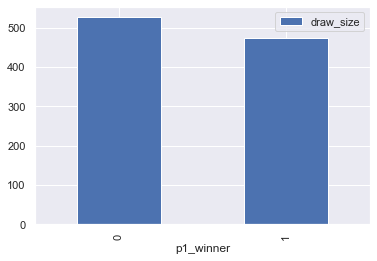

In [23]:
features[['p1_winner','draw_size']].groupby("p1_winner").count().plot(kind='bar')

# 2 - Generate Features and Ground Truth Using One Hot Encoding

For our categorical data, we are currently using label encoding. Label encoding basically assigned a unique number to each categorical value and we use this as features

Alternative method is to use one hot encoding. Each category will be coverted into a unique column - 1 will be assigned to the column if the value matches that column, all other columns will have 0 value. We will try this method to see if it makes a difference in our models

Our categories are:
* player id
* player hand
* player ioc (origin)
* tournament ID
* surface
* best_of

In [24]:
from sklearn.preprocessing import OneHotEncoder
import pickle

# def encode_columns(df: pd.DataFrame, col1: str, col2: str = None, col_labels: list = None) -> (pd.DataFrame, OneHotEncoder):
def ohe_columns(name: str, df: pd.DataFrame, col1: str, col2: str = None) -> (pd.DataFrame, OneHotEncoder):
    """
    Encodes columns and returns a DataFrame and encoder
    :param: name - encoder name to save
    :param: df - dataframe with data
    :param: col1 - name of first column to encode (ie, p1 column)
    :param: col2 - name of 2nd column to encode (ie, p2 column) - we need to do this so that the encoder knows about all values for p1 and p2
    
    :return: dataframe with encoded values and column names
    :return: encoder
    """
    encoded_return = None
    ohe = OneHotEncoder(handle_unknown='ignore', sparse = False, dtype=np.int)
    if col2:
        # sometimes not all values are in one column between p1 and p2, we have to melt them to fit the encoder
        ohe.fit(pd.melt(df[[col1, col2]])[["value"]])
        encoded_array1 = ohe.transform(df[[col1]])
        encoded_array2 = ohe.transform(df[[col2]])
        encoded_df = pd.DataFrame(encoded_array1, columns=[col1 + "_" + str(col) for col in ohe.categories_[-1]])
        encoded_df2 = pd.DataFrame(encoded_array2, columns=[col2 + "_" + str(col) for col in ohe.categories_[-1]])
        encoded_pd = pd.concat([encoded_df, encoded_df2], axis=1)
    else:
        encoded_array = ohe.fit_transform(df[[col1]])
        encoded_pd = pd.DataFrame(encoded_array, columns=[col1 + "_" + str(col) for col in ohe.categories_[-1]])

    # save off our encoder
    pickle.dump(ohe, open(f'{MODEL_DIR}/{name}_ohe.pkl', 'wb'))
    
    # drop old columns
    return_pd = pd.concat([df, encoded_pd], axis=1)
    if col2:
        return_pd = return_pd.drop([col1, col2], axis=1)
    else:
        return_pd = return_pd.drop([col1], axis=1)
    
    
    return return_pd, ohe



### let's recreate the diff dataset but we will encode categorical columns

ohe the following columns: 
player id
player hand
player ioc (origin)
tournament ID
surface

In [25]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 35 columns):
age_diff               1000 non-null int32
best_of                1000 non-null int32
draw_size              1000 non-null int32
ht_diff                1000 non-null int32
p1                     1000 non-null int32
p1_age                 1000 non-null float64
p1_hand                1000 non-null object
p1_hand_label          1000 non-null int32
p1_ht                  1000 non-null float64
p1_ioc                 1000 non-null object
p1_ioc_label           1000 non-null int32
p1_rank                1000 non-null int32
p1_seed                1000 non-null int32
p1_winner              1000 non-null int32
p2                     1000 non-null int32
p2_age                 1000 non-null float64
p2_hand                1000 non-null object
p2_hand_label          1000 non-null int32
p2_ht                  1000 non-null float64
p2_ioc                 1000 non-null object
p2_ioc_label          

In [26]:
def get_reverse_map(encoder: LabelEncoder) -> dict:
    """
    reverses label encoder mapping into a dictionary so we can map values back into original values
    :param: encoder - label encoder
    :return: dict with reverse mapping from label encoder
    """
    return {i: encoder.classes_[i] for i in range(0, len(encoder.classes_))}
    

To save time, instead of iterating and recreating the data set, we are going to reverse encode columns that we encoded using label encoder

Then we will use our ohe function to one hot encode these columns into more feature columns

In [27]:
# let's make a copy of our data

# raw_feature_columns = ["best_of", "draw_size", "round_label", "surface_label", "tourney_id_label", "tourney_level_label", "tourney_month", "tourney_year",
#                    "p1", "p1_age", "p1_hand_label", "p1_ht", "p1_ioc_label", "p1_rank", "p1_seed", 
#                    "p2", "p2_age", "p2_hand_label", "p2_ht", "p2_ioc_label", "p2_rank", "p2_seed", 
#                    "p1_winner"
#                   ]
# diff_columns = ["best_of", "draw_size", "round_label", "surface_label", "tourney_id_label", "tourney_level_label", "tourney_month", "tourney_year",
#                    "p1", "p1_hand_label", "p1_ioc_label", 
#                    "p2", "p2_hand_label", "p2_ioc_label", 
#                 "age_diff", "ht_diff", "seed_diff", "rank_diff",
#                    "p1_winner"
#                   ]

ohe_cols = ["best_of", "draw_size", "round_label", "surface", "tourney_id", "tourney_level_label", "tourney_month", "tourney_year",
                   "p1", "p1_hand", "p1_ioc", 
                   "p2", "p2_hand", "p2_ioc", 
                  "age_diff", "ht_diff", "seed_diff", "rank_diff",
                   "p1_winner"
                  ]


features_diff_ohe = features[ohe_cols].copy()

# reverse player hand
# hand_reverse_map = get_reverse_map(hand_le)
# features_ohe["p1_hand"] = features_ohe["p1_hand"].map(hand_reverse_map)
# features_ohe["p2_hand"] = features_ohe["p2_hand"].map(hand_reverse_map)

# reverse player ioc
# ioc_reverse_map = get_reverse_map(ioc_le)
# features_ohe["p1_ioc"] = features_ohe["p1_ioc"].map(ioc_reverse_map)
# features_ohe["p2_ioc"] = features_ohe["p2_ioc"].map(ioc_reverse_map)

# reverse surface
# surface_reverse_map = get_reverse_map(surface_le)
# features_ohe["surface_label"] = features_ohe["surface_label"].map(surface_reverse_map)


print(features_diff_ohe[["p1_hand", "p2_hand", "p1_ioc", "p2_ioc", "surface", "p1", "p2", "tourney_id", "best_of"]].head())

features_diff_ohe.info()

  p1_hand p2_hand p1_ioc p2_ioc surface      p1      p2 tourney_id  best_of
0       r       l    ger    ger    clay  109054  109739       0414        3
1       l       r    esp    arg    clay  105077  104919       0414        3
2       r       r    ita    fra    clay  106065  104792       0414        3
3       r       r    svk    bih    clay  106075  106000       0414        3
4       r       r    ger    esp    clay  200484  103970       0414        3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
best_of                1000 non-null int32
draw_size              1000 non-null int32
round_label            1000 non-null int32
surface                1000 non-null object
tourney_id             1000 non-null object
tourney_level_label    1000 non-null int32
tourney_month          1000 non-null int32
tourney_year           1000 non-null int32
p1                     1000 non-null int32
p1_hand                1000 non-null object
p1_io

In [28]:
features_diff_ohe, hand_ohe = ohe_columns("hand", features_diff_ohe, "p1_hand", "p2_hand")
features_diff_ohe, surface_ohe = ohe_columns("surface", features_diff_ohe, "surface")
features_diff_ohe, ioc_ohe = ohe_columns("ioc", features_diff_ohe, "p1_ioc", "p2_ioc")
features_diff_ohe, tourney_id_ohe = ohe_columns("tourney_id", features_diff_ohe, "tourney_id")
features_diff_ohe, player_id_ohe = ohe_columns("player_id", features_diff_ohe, "p1", "p2")
features_diff_ohe, best_of_ohe = ohe_columns("best_of", features_diff_ohe, "best_of")


features_diff_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 582 entries, draw_size to best_of_5
dtypes: int32(10), int64(572)
memory usage: 4.4 MB


In [29]:
features_diff_ohe.head()

,draw_size,round_label,tourney_level_label,tourney_month,tourney_year,age_diff,ht_diff,seed_diff,rank_diff,p1_winner,...,p2_200059,p2_200175,p2_200282,p2_200484,p2_200514,p2_200615,p2_202358,p2_202385,best_of_3,best_of_5
0,32,5,4,7,2018,1,0,18,302,1,...,0,0,0,0,0,0,0,0,1,0
1,32,5,4,7,2018,0,0,3,4,0,...,0,0,0,0,0,0,0,0,1,0
2,32,5,4,7,2018,-6,-8,-4,-15,0,...,0,0,0,0,0,0,0,0,1,0
3,32,5,4,7,2018,0,13,22,89,1,...,0,0,0,0,0,0,0,0,1,0
4,32,5,4,7,2018,-18,10,12,210,1,...,0,0,0,0,0,0,0,0,1,0


In [30]:
features_diff_ohe.to_csv(FEATURE_FILE_DIFF_OHE, index=False)

In [31]:
features_diff_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 582 entries, draw_size to best_of_5
dtypes: int32(10), int64(572)
memory usage: 4.4 MB


In [32]:
features_diff_ohe.shape

(1000, 582)

## We will use raw data and encode categorical columns

In [33]:

raw_ohe_columns = ["best_of", "draw_size", "round_label", "surface", "tourney_id", "tourney_level_label", "tourney_month", "tourney_year",
                   "p1", "p1_age", "p1_hand", "p1_ht", "p1_ioc", "p1_rank", "p1_seed", 
                   "p2", "p2_age", "p2_hand", "p2_ht", "p2_ioc", "p2_rank", "p2_seed", 
                   "p1_winner"
                  ]

features_ohe = features[raw_ohe_columns].copy()
print(features_ohe[["p1_hand", "p2_hand", "p1_ioc", "p2_ioc", "surface", "p1", "p2", "tourney_id", "best_of"]].head())


  p1_hand p2_hand p1_ioc p2_ioc surface      p1      p2 tourney_id  best_of
0       r       l    ger    ger    clay  109054  109739       0414        3
1       l       r    esp    arg    clay  105077  104919       0414        3
2       r       r    ita    fra    clay  106065  104792       0414        3
3       r       r    svk    bih    clay  106075  106000       0414        3
4       r       r    ger    esp    clay  200484  103970       0414        3


In [34]:
features_ohe, hand_ohe = ohe_columns("hand", features_ohe, "p1_hand", "p2_hand")
features_ohe, surface_ohe = ohe_columns("surface", features_ohe, "surface")
features_ohe, ioc_ohe = ohe_columns("ioc", features_ohe, "p1_ioc", "p2_ioc")
features_ohe, tourney_id_ohe = ohe_columns("tourney_id", features_ohe, "tourney_id")
features_ohe, player_id_ohe = ohe_columns("player_id", features_ohe, "p1", "p2")
features_ohe, best_of_ohe = ohe_columns("best_of", features_ohe, "best_of")


features_ohe.head()

,draw_size,round_label,tourney_level_label,tourney_month,tourney_year,p1_age,p1_ht,p1_rank,p1_seed,p2_age,...,p2_200059,p2_200175,p2_200282,p2_200484,p2_200514,p2_200615,p2_202358,p2_202385,best_of_3,best_of_5
0,32,5,4,7,2018,24.11,185.127327,349,32,23.10,...,0,0,0,0,0,0,0,0,1,0
1,32,5,4,7,2018,30.51,188.000000,40,12,31.19,...,0,0,0,0,0,0,0,0,1,0
2,32,5,4,7,2018,25.81,184.673946,22,6,31.89,...,0,0,0,0,0,0,0,0,1,0
3,32,5,4,7,2018,25.71,185.127327,113,26,26.17,...,0,0,0,0,0,0,0,0,1,0
4,32,5,4,7,2018,17.74,185.127327,272,31,36.31,...,0,0,0,0,0,0,0,0,1,0


In [35]:
features_ohe.to_csv(FEATURE_FILE_OHE, index=False)
features_ohe.shape

(1000, 586)

# Create dataset with both raw and diff data

In [36]:

raw_diff_ohe_columns = ["best_of", "draw_size", "round_label", "surface", "tourney_id", "tourney_level_label", "tourney_month", "tourney_year",
                   "p1", "p1_age", "p1_hand", "p1_ht", "p1_ioc", "p1_rank", "p1_seed", 
                   "p2", "p2_age", "p2_hand", "p2_ht", "p2_ioc", "p2_rank", "p2_seed", 
                  "age_diff", "ht_diff", "seed_diff", "rank_diff",
                   "p1_winner"
                  ]



features_raw_diff_ohe = features[raw_diff_ohe_columns].copy()
print(features_raw_diff_ohe[["p1_hand", "p2_hand", "p1_ioc", "p2_ioc", "surface", "p1", "p2", "tourney_id", "best_of"]].head())


  p1_hand p2_hand p1_ioc p2_ioc surface      p1      p2 tourney_id  best_of
0       r       l    ger    ger    clay  109054  109739       0414        3
1       l       r    esp    arg    clay  105077  104919       0414        3
2       r       r    ita    fra    clay  106065  104792       0414        3
3       r       r    svk    bih    clay  106075  106000       0414        3
4       r       r    ger    esp    clay  200484  103970       0414        3


In [37]:
features_raw_diff_ohe, hand_ohe = ohe_columns("hand", features_raw_diff_ohe, "p1_hand", "p2_hand")
features_raw_diff_ohe, surface_ohe = ohe_columns("surface", features_raw_diff_ohe, "surface")
features_raw_diff_ohe, ioc_ohe = ohe_columns("ioc", features_raw_diff_ohe, "p1_ioc", "p2_ioc")
features_raw_diff_ohe, tourney_id_ohe = ohe_columns("tourney_id", features_raw_diff_ohe, "tourney_id")
features_raw_diff_ohe, player_id_ohe = ohe_columns("player_id", features_raw_diff_ohe, "p1", "p2")
features_raw_diff_ohe, best_of_ohe = ohe_columns("best_of", features_raw_diff_ohe, "best_of")


features_raw_diff_ohe.head()

,draw_size,round_label,tourney_level_label,tourney_month,tourney_year,p1_age,p1_ht,p1_rank,p1_seed,p2_age,...,p2_200059,p2_200175,p2_200282,p2_200484,p2_200514,p2_200615,p2_202358,p2_202385,best_of_3,best_of_5
0,32,5,4,7,2018,24.11,185.127327,349,32,23.10,...,0,0,0,0,0,0,0,0,1,0
1,32,5,4,7,2018,30.51,188.000000,40,12,31.19,...,0,0,0,0,0,0,0,0,1,0
2,32,5,4,7,2018,25.81,184.673946,22,6,31.89,...,0,0,0,0,0,0,0,0,1,0
3,32,5,4,7,2018,25.71,185.127327,113,26,26.17,...,0,0,0,0,0,0,0,0,1,0
4,32,5,4,7,2018,17.74,185.127327,272,31,36.31,...,0,0,0,0,0,0,0,0,1,0


In [38]:
# print out our non-encoded columns
import re
print([col for col in features_raw_diff_ohe.columns if not re.match(r'(p1|p2)_[\d]+', col) and not re.match(r"(p1|p2)_ioc_", col) and not re.match("tourney_id_", col)])

['draw_size', 'round_label', 'tourney_level_label', 'tourney_month', 'tourney_year', 'p1_age', 'p1_ht', 'p1_rank', 'p1_seed', 'p2_age', 'p2_ht', 'p2_rank', 'p2_seed', 'age_diff', 'ht_diff', 'seed_diff', 'rank_diff', 'p1_winner', 'p1_hand_l', 'p1_hand_r', 'p1_hand_u', 'p2_hand_l', 'p2_hand_r', 'p2_hand_u', 'surface_clay', 'surface_hard', 'best_of_3', 'best_of_5']


In [39]:
features_raw_diff_ohe.to_csv(FEATURE_FILE_RAW_DIFF_OHE, index=False)
features_raw_diff_ohe.shape

(1000, 590)